2137
toal: 27766
clipped: 1280


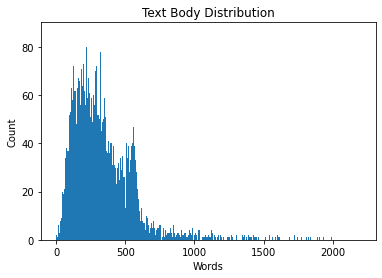

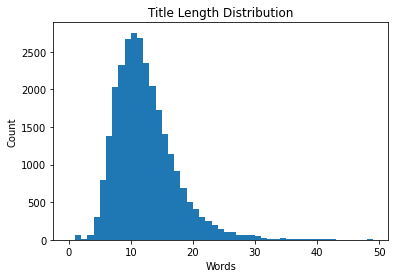

In [6]:
import readers
from icecream import ic
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

temp_dir = 'data/'

#### Anecdotes
corpus = readers.ScruplesCorpus(data_dir=temp_dir)



corpus2 = readers.ScruplesCorpusDataset(
            data_dir=temp_dir,
            split='train',
            transform=None,
            label_transform=None,
            label_scores_transform=None)


#### Graph Out Word Distributions ####


#### Graph out text body distribution ####
fig,ax = plt.subplots(1,1)

#print(corpus.train[1]["text"].astype(str).apply(len).max())
text_len=np.zeros(corpus.train[1]["text"].shape,dtype=np.int32)
for i,title in enumerate(corpus.train[1]["text"]):
    text_len[i] =int(len(title.split(" ")))

print(np.max(text_len))
print("toal:",len(text_len))
print("clipped:",len(text_len[text_len > 750]))
ax.hist(text_len, bins = range(0,2200))
ax.set_title("Text Body Distribution")
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


#### Graph out title distribution ####
fig,ax = plt.subplots(1,1)
#print(corpus.train[1]["title"].astype(str).apply(len).mean())
lens=np.zeros(corpus.train[1]["title"].shape,dtype=np.int32)
for i,title in enumerate(corpus.train[1]["title"]):
    lens[i] =int(len(title.split(" ")))
#print(lens)

#print(np.mean(lens))
ax.hist(lens, bins = range(0,50))
# ax.set_xticks(range(0,50))
ax.set_title("Title Length Distribution")
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

In [13]:
print(corpus.test[1])

test = corpus.test[1]
xtest = test['text']
ytest = test['title']
_, _, pairs_test = prepareData( xtest, ytest , False)

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

                                                  title  \
0                    AITA for wanting my father to die?   
1                         AITA for forgetting to flush?   
2               AITA Dinner plans and who's responsible   
3     AITA for being upset about my SO using our ope...   
4              AITA for wanting to get rid of my puppy?   
...                                                 ...   
2495    AITA For cutting a toxic friend out of my life?   
2496              AITA Because my friend feels awkward?   
2497  AITA for leaving heartbroken a guy who had a c...   
2498  AITA - My husband and I are struggling in our ...   
2499     AITA for spending more time with other people?   

                                                   text  
0        Throwaway for obvious reasons.\n\n   I drop...  
1     For background, my mom's cousin is staying wit...  
2     AITA Dinner plans and who's responsible\n\n&am...  
3     Background: I can't give much detail because o...  
4

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(10):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
tensor([[-1.1559, -0.9408, -1.2210],
        [-1.1377, -0.9563, -1.2203],
        [-1.1656, -0.9659, -1.1790],
        [-1.2338, -0.8290, -1.3008],
        [-1.2095, -0.8931, -1.2301]])
tensor([[-1.1159, -0.9009, -1.3236],
        [-1.0990, -0.9133, -1.3259],
        [-1.1297, -0.9042, -1.3020],
        [-1.1702, -0.7882, -1.4480],
        [-1.1695, -0.8135, -1.4017]])


In [36]:
from torch.utils.data import DataLoader
pred = 'AITA for eating ass?'
# dataset = 
# dataloader = DataLoader(dataset, batch_size=args.batch_size)
print(corpus.train[1]['title'][0])

AITA for hiding my controller?


In [38]:
criterion = nn.CrossEntropyLoss()

loss = criterion(pred, corpus.train[1]['title'][0])

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not str

In [39]:
class encoder(nn.Module):
    def __init__(self, input_size=400, hidden_size=512, vocab_size=1500, caption_max_len=30, device="cpu"):
        super(encoder, self).__init__()
        self.feature_size = feature_size
        self.caption_max_len = caption_max_len
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.device = device
        self.decoder_input_size = 2 * self.hidden_size  # output of image encoder + word embedding size

        self.relu = nn.ReLU()
        self.linear_f2f = nn.Linear(self.image_feature_size, self.hidden_size)
        self.dropout = nn.Dropout(0.8)
        self.lstm_v2h = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True)
        self.lstm_h2c = nn.LSTM(self.decoder_input_size, self.hidden_size, batch_first=True)

        self.embedding = nn.Embedding(self.vocab_size, self.hidden_size)
        self.linear_h2c = nn.Linear(self.hidden_size, self.vocab_size)

    # caption for training, or index of <BOS> for inference
    def forward(self, video_features, caption=None, word2idx=None):
        # Video features -> hidden layer
        video_features = self.relu(video_features)
        video_features = self.dropout(video_features)
        video_features = self.linear_f2f(video_features)
        batch_size, num_video_features = video_features.size(0), video_features.size(1)
        video_padding = torch.zeros((batch_size, self.caption_max_len - 1, self.hidden_size), device=self.device)
        padded_video_features = torch.cat([video_features, video_padding], dim=1)
        video_out, video_hidden = self.lstm_v2h(padded_video_features)

        if self.training:
            # Encoded videos feature -> caption decoder
            # caption input is from <BOS> to seq length -1
            embedded_caption = self.embedding(caption[:, :-1])          # size: (B, 31, 512)
            caption_padding = torch.zeros((batch_size, num_video_features, self.hidden_size), device=self.device)
            # Append empty embedding state (video part) before captions
            decoder_input = torch.cat([caption_padding, embedded_caption], dim=1)
            # Stack video feature and word embedding
            decoder_input = torch.cat([video_out, decoder_input], dim=2)
            caption_out, _ = self.lstm_h2c(decoder_input)
            caption_out = caption_out[:, num_video_features:]
            caption_out = self.dropout(caption_out)
            caption_out = self.linear_h2c(caption_out)
            caption_out = torch.permute(caption_out, (0, 2, 1))  # To follow cross entropy loss: (B, C, k...) format
            return caption_out
        else:
            caption_padding = torch.zeros((batch_size, num_video_features, self.hidden_size), device=self.device)
            vid_feature_input = torch.cat([video_out[:, :num_video_features, :], caption_padding], dim=2)
            # Video features -> captions
            caption_out, caption_hidden = self.lstm_h2c(vid_feature_input)
            # feeds <BOS> into LSTM
            bos_tensor = torch.full([batch_size, 1], word2idx["<BOS>"], device=self.device)
            results = bos_tensor.clone()

            bos_tensor = self.embedding(bos_tensor)
            bos_tensor = torch.cat([video_out[:, num_video_features, :].unsqueeze(dim=1), bos_tensor], dim=2)
            next_word, next_hidden = self.lstm_h2c(bos_tensor, caption_hidden)

            for idx in range(self.caption_max_len - 2):
                next_word = self.linear_h2c(next_word)
                word_out = next_word.max(dim=2)[1]
                results = torch.hstack([results, word_out])
                word_out = self.embedding(word_out)

                # concat previous word embedding with video features
                next_word = torch.cat([video_out[:, num_video_features+idx+1, :].unsqueeze(dim=1), word_out], dim=2)
                next_word, next_hidden = self.lstm_h2c(next_word, next_hidden)

            return results

In [48]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        args,
    ):
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('data/reddit-cleanjokes.txt')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.args.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.args.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.args.sequence_length+1]),
        )
    
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train(dataset, model, args):
    model.train()

    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(args.max_epochs):
        state_h, state_c = model.init_state(args.sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
def predict(dataset, model, text, next_words=100):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words
parser = argparse.ArgumentParser()
parser.add_argument('--max-epochs', type=int, default=10)
parser.add_argument('--batch-size', type=int, default=256)
parser.add_argument('--sequence-length', type=int, default=4)
args = parser.parse_args()
dataset = Dataset('./272/project/CS272-Final-Project/data/reddit-cleanjokes.txt')
model = Model(dataset)

train(dataset, model, args)
print(predict(dataset, model, text='Knock knock. Whos there?'))

AttributeError: 'str' object has no attribute 'sequence_length'

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

NameError: name 'nn' is not defined